In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getpid())
%cd ../../

5971
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.measurement as mse
import pylib.mix as mix
import pylib.EM_1D_sim as sim

path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"
flag_save_ = True

In [11]:
# ---------------------------------------------------------------------
# --- CLASSICAL: solve ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(sim)

path_root_ = "../QuCF/simulations/matrix-inversion-EM/"

dd_work = sim.init(nqx = 8, nq_layers = 1, epss = [1,4], r0 = 4, kx = 7.2)
A, b  = sim.form_matrix(dd_work, flag_norm = True)

# --- classical simulation ---
psi   = sim.solve_system(A, b, 0)
vv_cl = sim.get_vars(psi, dd_work)
Ey_cl = vv_cl["Ey"]
Bz_cl = vv_cl["Bz"]

Modeling: Nx = 256

i*w + ih: 1.771e+01+1.000e+00j
i2h: 8.854e+00

--- Solve the system by the Gaussian method ---
time for inv. calc.: 8.356e-02 s


In [8]:
# ------------------------------------------------------
# --- Find the condition number ---
# ------------------------------------------------------
_, s, _ = np.linalg.svd(A)
kappa_ref_ = np.max(np.abs(s)) / np.min(np.abs(s[np.nonzero(s)]))
print("nx, Nx: {:d}, {:d}".format(dd_work["nqx"], dd_work["Nx"]))
print("condition number as |sing_max|/|sing_min|: \t{:0.1f}".format(kappa_ref_))
del s

nx, Nx: 12, 4096
condition number as |sing_max|/|sing_min|: 	27690.6


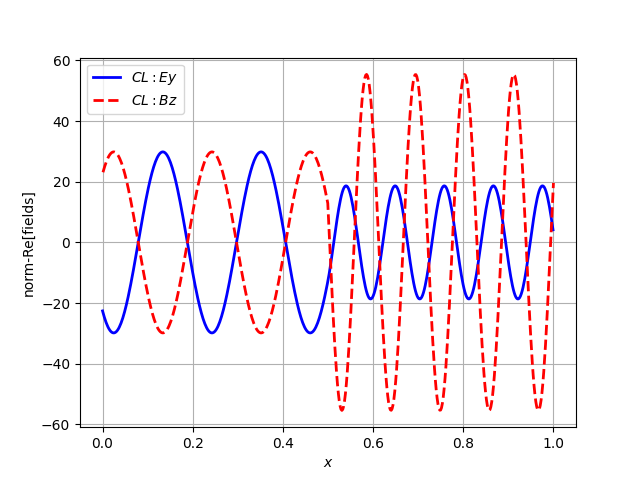

In [5]:
# ----------------------------------------------------------------------------------
# --- CLASSICAL: Plot variables in space ---
# ----------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(
    vv_cl["xe"], np.real(Ey_cl), 
    color='b',  
    linewidth = 2, linestyle='-', 
    label = "$CL: Ey$"
)
ax.plot(
    vv_cl["xb"], np.real(Bz_cl), 
    color='r',  
    linewidth = 2, linestyle='--', 
    label = "$CL: Bz$"
)
plt.xlabel('$x$')
plt.ylabel("norm-Re[fields]")
ax.legend()
plt.grid(True)
plt.show()

In [5]:
for i in range(30):
    plt.close()

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_n8_k3200_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  02-22-2024 14:29:54

nx: 8
kappa_qsvt: 3.200e+03
max. relative err: 2.472e-05


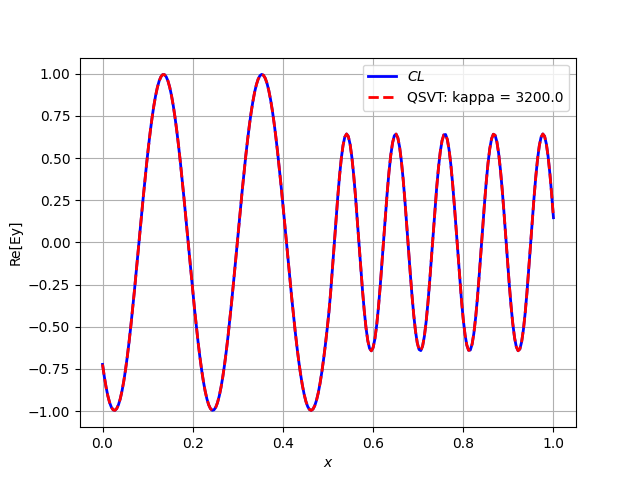

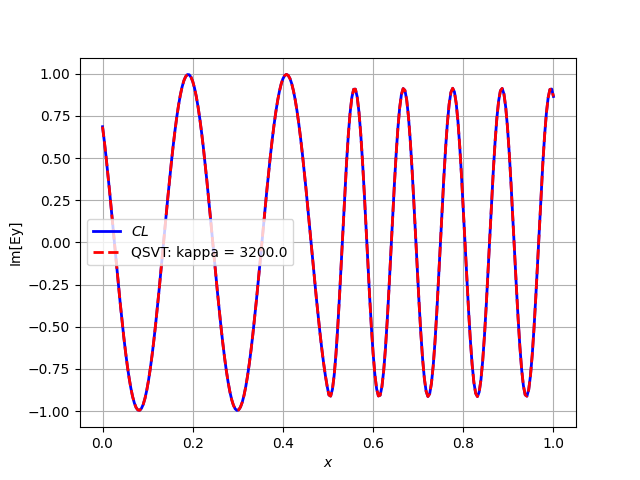

/tmp/ipykernel_5971/2035354533.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


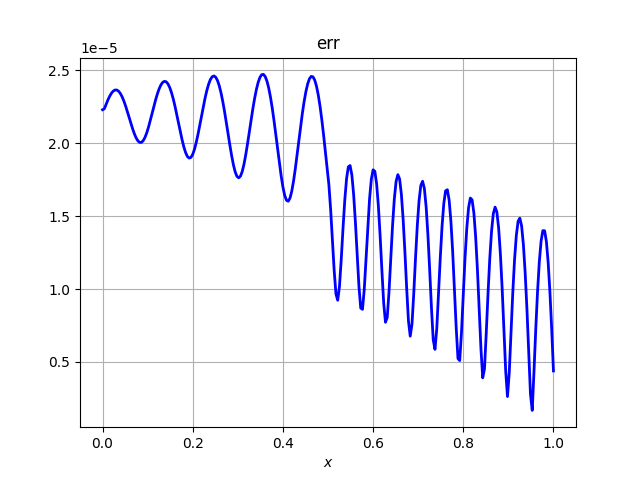

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_ref_real.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_ref_imag.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_reco_real.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_reco_imag.dat


In [18]:
# ----------------------------------------------------------------------------------
# --- QC convergence: KAPPA ---
# ----------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

def read_qsvt_data(kappa_qsvt):
    oor_curr = mse.MeasOracle__()
    oor_curr.pname_ = "EM_n{:d}_k{:d}".format(dd_work["nqx"], kappa_qsvt)
    oor_curr.path_  = path_root_
    oor_curr.open()
    oor_curr.read_qsvt()
    oor_curr.set_zero_ancillae_work_states(id_input_state = 0)
    
    rescaling_factor = oor_curr.dd_["MI"]["rescaling_factor"]
    kappa_qc = oor_curr.dd_["MI"]["par"]
    if np.abs(kappa_qc - kappa_qsvt) > 1e-4:
        print()
        print("<<< ERROR: a wrong QSVT parameter.>>>")
        print()
    
    # --- x-grid ---
    x_e_qc_curr = oor_curr.get_x_grid("j")
    shift_x = (x_e_qc_curr[1] - x_e_qc_curr[0])/2.
    x_b_qc_curr = shift_x + x_e_qc_curr # coord.-axis for the magnetic field;

    # --- E, B fields ---
    Ey_qc_curr = oor_curr.get_var_x({"d": 0}, "j")
    Bz_qc_curr = oor_curr.get_var_x({"d": 1}, "j")
    
    # --- renormalize the fields ---
    coef_norm = kappa_qc / rescaling_factor
    Ey_qc_curr = coef_norm * Ey_qc_curr
    Bz_qc_curr = coef_norm * Bz_qc_curr
    return Ey_qc_curr, x_e_qc_curr
# ------------------------------------------------------------------------------

# --- Reading QuCF data ---
kappa_qsvt = 3200
Ey_qc, x_e_qc = read_qsvt_data(kappa_qsvt)
    
# --- correct the global factor ---
y_reco = 1j * Ey_qc
y_reco.imag = - y_reco.imag
y_ref = Ey_cl

# --- Relative error ---
# norm_ref  = np.sqrt( np.sum( np.abs(y_ref)**2 ) )
# norm_reco = np.sqrt( np.sum( np.abs(y_reco)**2 ) )
# norm_diff = np.abs(y_ref/norm_ref - y_reco/norm_reco)

norm_ref  = np.max(np.abs(y_ref))
norm_reco = norm_ref
norm_diff = np.abs(y_ref - y_reco) / norm_ref


max_rel_err = np.max(np.abs(norm_diff))

# --- Print some parameters and results ---
print()
print("nx: {:d}".format(dd_work["nqx"]))
print("kappa_qsvt: {:0.3e}".format(kappa_qsvt))
print("max. relative err: {:0.3e}".format(max_rel_err))

# --- Plotting: comparison: Re ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    vv_cl["xe"], y_ref.real/norm_ref, 
    color='b', linewidth = 2, linestyle='-', 
    label = "$CL$"
)
ax.plot(
    x_e_qc, y_reco.real/norm_reco, 
    color="r", linewidth = 2, linestyle='--', 
    label = "QSVT: kappa = {:0.1f}".format(kappa_qsvt)
)
plt.xlabel('$x$')
plt.ylabel("Re[Ey]")
ax.legend()
plt.grid(True)
plt.show()

# --- Plotting: comparison: Im ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    vv_cl["xe"], y_ref.imag/norm_ref, 
    color='b', linewidth = 2, linestyle='-', 
    label = "$CL$"
)
ax.plot(
    x_e_qc, y_reco.imag/norm_reco, 
    color="r", linewidth = 2, linestyle='--', 
    label = "QSVT: kappa = {:0.1f}".format(kappa_qsvt)
)
plt.xlabel('$x$')
plt.ylabel("Im[Ey]")
ax.legend()
plt.grid(True)
plt.show()


# --- Plotting: relative error ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(vv_cl["xe"], norm_diff, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.title("err")
plt.grid(True)
plt.show()


if flag_save_:
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_ref_real.dat", 
        vv_cl["xe"], y_ref.real/norm_ref
    )
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_ref_imag.dat", 
        vv_cl["xe"], y_ref.imag/norm_ref
    )
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_reco_real.dat", 
        x_e_qc, y_reco.real/norm_reco
    )
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_reco_imag.dat", 
        x_e_qc, y_reco.imag/norm_reco
    )

del y_reco, y_ref

In [9]:
# ----------------------------------------------------------------
# --- Save scans ---
# ----------------------------------------------------------------
def save_scans():
    # --- kappa versus nx ---
    nx_array = [    7,     8,      9,     10,      11,      12]
    k_array  = [407.5, 800.7, 1748.3, 4125.1, 10426.3, 27690.6]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_kappa_nx.dat", 
        nx_array, k_array
    )

    # nx = 7: eps vs kappa_qsvt:
    k_qsvt_array = \
        [      500,       800,      1000,      1200,      1500,      1600,      2000]
    err_array    = \
        [1.663e-02, 1.175e-03, 1.132e-04, 7.933e-06, 1.262e-06, 1.052e-06, 7.889e-07]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_err_nx7.dat", 
        k_qsvt_array, np.log10(err_array)
    )
    
    # nx = 8: eps vs kappa_qsvt:
    k_qsvt_array = [     1600,      2000,      2400,      2800,      3200]
    err_array    = [7.275e-04, 7.084e-05, 5.459e-06, 1.299e-06, 9.400e-07]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_err_nx8.dat", 
        k_qsvt_array, np.log10(err_array)
    )
    
    # nx = 9: eps vs kappa_qsvt:
    k_qsvt_array = [     3000,      4000,      5250,      6000,      7000]
    err_array    = [1.450e-03, 1.351e-04, 3.513e-06, 1.019e-06, 6.496e-07]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_EM_err_nx9.dat", 
        k_qsvt_array, np.log10(err_array)
    )
    return
# -----------------------------------
save_scans()

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_kappa_nx.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx7.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx8.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx9.dat


In [11]:
# --- Print angles for the oracle ---
import cmath
mix.reload_module(mix)
mix.reload_module(sim)

d_H = dd_work["coef-superposition"] 
N_layers = dd_work["N-layers"]

print()
w, w_epss, i2h, wph, wmh = sim.print_get_norm_h_element_EB(dd_work)

# i*w and i*w*eps (minus because of the Rx gate):
r_w = 2*np.arcsin(- w * d_H)

r_weps = np.zeros(N_layers)
for ii in range(N_layers):
    r_weps[ii] = 2*np.arcsin(- w_epss[ii] * d_H)

# i*w*epss[0] near the left edge (minus because of the Rx gate):
r_weps_el = 2*np.arcsin(- w_epss[0] * d_H*np.sqrt(d_H))

# i*w near the right edge (minus because of the Rx gate):
r_w_er = 2*np.arcsin(- w * d_H*np.sqrt(d_H))

# 1/(2h) and - 1/(2h):
r_2h  = 2*np.arcsin(i2h * d_H**2)
r_m2h = 2*np.arcsin(-i2h * d_H**2)

# 1/(2h) and - 1/(2h) near the edge:
r_2he  = 2*np.arcsin(i2h * d_H*np.sqrt(d_H)) - r_2h
r_m2he = 2*np.arcsin(-i2h * d_H*np.sqrt(d_H)) - r_m2h

# i*w + 1/h:
r, a = cmath.polar(wph)
r_wph = 2*np.arcsin(r * d_H*np.sqrt(d_H))
a_wph = -2*a

# i*w - 1/h:
r, a = cmath.polar(wmh)
r_wmh = 2*np.arcsin(r * d_H**2)
a_wmh = -2*a

# to zero elements:
r_pi  = - r_2h
r_mpi = - r_m2h

print()
print("--- Resulting BE parameters ---")
print("nqx  \t{:d}".format(dd_work["nqx"]))
print("Nx_layer  \t{:d}".format(dd_work["Nx-layer"]))
print()
print("r_w  \t\t{:0.14e}".format(r_w))
for ii in range(N_layers):
    print("r_weps{:d}  \t{:0.14e}".format(ii, r_weps[ii]))
print("r_weps_el  \t{:0.14e}".format(r_weps_el))
print("r_w_er  \t{:0.14e}".format(r_w_er))
print()
print("r_2h  \t{:0.14e}".format(r_2h))
print("r_m2h  \t{:0.14e}".format(r_m2h))
print("r_2he \t{:0.14e}".format(r_2he))
print("r_m2he \t{:0.14e}".format(r_m2he))
print()
print("r_wph  \t{:0.14e}".format(r_wph))
print("a_wph  \t{:0.14e}".format(a_wph))
print()
print("r_wmh  \t{:0.14e}".format(r_wmh))
print("a_wmh  \t{:0.14e}".format(a_wmh))
print()
print("r_pi   \t{:0.14e}".format(r_pi))
print("r_mpi  \t{:0.14e}".format(r_mpi))

del r, a


N-layers: 2
Nx in one layer: 512
max. value for norm: 1.421e+02
norm value: 5.683e+02
coef-superposition: 2

w: 	1.760e-03
0-th layer: w * eps: 	1.760e-03
1-th layer: w * eps: 	7.038e-03
1/(2h): 	6.250e-02
w*j + 1/h: 	1.250e-01+1.760e-03j
w*j - 1/h: 	-1.250e-01+1.760e-03j

--- Resulting BE parameters ---
nqx  	10
Nx_layer  	512

r_w  		-7.03813769368146e-03
r_weps0  	-7.03813769368146e-03
r_weps1  	-2.81534224440109e-02
r_weps_el  	-9.95345032409271e-03
r_w_er  	-9.95345032409271e-03

r_2h  	5.05360510284157e-01
r_m2h  	-5.05360510284157e-01
r_2he 	-1.49939308593934e-01
r_m2he 	1.49939308593934e-01

r_wph  	7.22809134783379e-01
a_wph  	-2.81506335046723e-02

r_wmh  	1.04731194401208e+00
a_wmh  	-6.25503467367491e+00

r_pi   	-5.05360510284157e-01
r_mpi  	5.05360510284157e-01
